# CNN 2D Classifier Training

This notebook demonstrates a 5 layered Multisacle CNN  trained to classify spectra from single spectra and lensed spectra. In this notebook the classifier does *not* assume we work in the host rest frame.

Required software:
* TensorFlow2
* [desihub software](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) (with usual dependencies).

In [1]:
from glob import glob

import pickle 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import platform

In [2]:
mpl.rc('font', size=18)

## Input Spectra

Input DESI spectra generated from the pickle notebook. Then divide them into training and test sets for the classifier.

In [3]:
lens_flux=[]
with open('data/lens_flux-2D.data', 'rb') as filehandle:
    # read the data as binary data stream
    items=pickle.load(filehandle)
    for i in items:
        lens_flux.append(i)


In [4]:
lens = np.asarray(lens_flux)

In [5]:
lens.shape

(11891, 60, 60)

In [6]:
single_flux=[]

with open('data/bg_flux-2D.data', 'rb') as filehandle:
    # read the data as binary data stream
    items=pickle.load(filehandle)
    for i in items:
        single_flux.append(i)


In [7]:
single = np.asarray(single_flux)

In [8]:
single.shape

(13966, 60, 60)

In [9]:
nlens, nylen, nxlen = lens.shape
nsingle, nylen, nxlen = single.shape

### Set up Training Sets and Labels

0. "lens" combined spectra
0. "single" single spectra 

In [10]:
 x = np.concatenate([lens, 
                    single]).reshape(-1, nylen, nxlen)

labels = ['Lens',
           'Single'
          ]
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate( [np.full(nlens, 0), 
                         np.full(nsingle, 1)
                       ]))


### Plot Image to check the CNN's input

#### Plot Flux

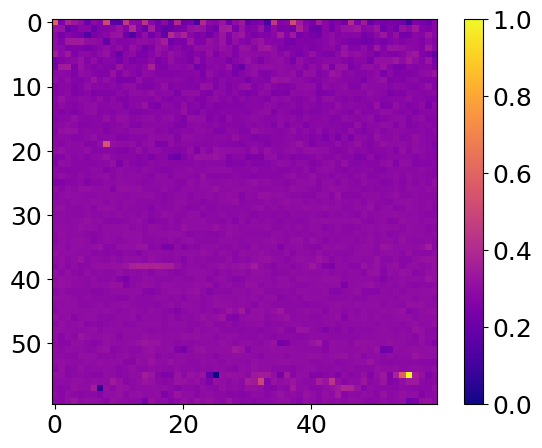

In [11]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca()
im = ax.imshow(lens[24,:,:], cmap='plasma')
ax.autoscale(False)
cb = fig.colorbar(im, ax=ax)

fig.savefig('cnn-inputs.png', dpi=300, transparent=True, edgecolor='none', bbox_inches='tight')

## CNN Network Setup

Train network with TensorFlow+Keras.

In [12]:
#import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
def network(ncat, input_shape=(60,60,1), learning_rate=1.8225460564333567e-05, reg=0.05, dropout=0.5, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """

    # input flux and ivar
    visible_flux = Input((60,60,1), name='Input_Spec1')
    
    # First Branch - Flux
    
    # first feature extractor
    conv1_flux = Conv2D(28, kernel_size=4, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X_flux = BatchNormalization(axis=2)(conv1_flux)
    pool1_flux = MaxPooling2D(pool_size=(3, 3))(X_flux)
    flat1_flux = Flatten()(pool1_flux)
    
     # second feature extractor
    conv2_flux = Conv2D(28, kernel_size=8, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X2_flux = BatchNormalization(axis=2)(conv2_flux)
    pool2_flux = MaxPooling2D(pool_size=(3, 3))(X2_flux)
    flat2_flux = Flatten()(conv2_flux)
    
     # third feature extractor
    conv3_flux = Conv2D(28, kernel_size=16, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X3_flux = BatchNormalization(axis=2)(conv3_flux)
    pool3_flux = MaxPooling2D(pool_size=(3, 3))(X3_flux)
    flat3_flux = Flatten()(pool3_flux)
    
     # Fourth feature extractor
    conv4_flux = Conv2D(28, kernel_size=32, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X4_flux = BatchNormalization(axis=2)(conv4_flux)
    pool4_flux = MaxPooling2D(pool_size=(3, 3))(X4_flux)
    flat4_flux = Flatten()(pool4_flux)
    
    # Fifth feature extractor
    conv5_flux = Conv2D(28, kernel_size=56, activation='relu',kernel_regularizer=regularizers.l2(reg))(visible_flux)
    X5_flux = BatchNormalization(axis=2)(conv4_flux)
    pool5_flux = MaxPooling2D(pool_size=(3, 3))(X5_flux)
    flat5_flux = Flatten()(pool5_flux)
    
   # merge feature extractors for flux and ivar
    merge_flux = concatenate([flat1_flux,flat2_flux,flat3_flux,flat4_flux,flat5_flux])
    
    # interpretation layer
    hidden1 = Dense(128, activation='relu')(merge_flux)
    droput=Dropout(rate=dropout, seed=seed)(hidden1)
#     z = Dense(4, activation="relu")(combined)
#     z = Dense(2, activation="softmax")(z)

    # prediction output # softmax
    output = Dense(2, activation='softmax')(droput)
    
    final_model = Model(inputs=visible_flux, outputs=output)
    final_model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return final_model

In [14]:
model = network(ncat=y.shape[1])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
ckpt = ModelCheckpoint(filepath='checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5')

2023-07-23 12:31:15.510609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 12:31:15.956389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0
/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Spec1 (InputLayer)       [(None, 60, 60, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 57, 57, 28)   476         ['Input_Spec1[0][0]']            
                                                                                                  
 conv2d_2 (Conv2D)              (None, 45, 45, 28)   7196        ['Input_Spec1[0][0]']            
                                                                                                  
 conv2d_3 (Conv2D)              (None, 29, 29, 28)   28700       ['Input_Spec1[0][0]']            
                                                                                              

## Train and Test

Split the data into training and testing (+ validation) samples and fit the network weights.

In [16]:
from sklearn.model_selection import train_test_split

def train_test_validate(x, y, train_size=0.75, test_size=0.125, val_size=0.125):
    # Ensure proper normalization.
    if train_size + test_size + val_size != 1:
        norm = train_size + test_size + val_size
        train_size = train_size/norm
        test_size = test_size/norm
        val_size = val_size/norm
        print('Renormalized to train {:g}, test {:g}, and validate {:g}'.format(train_size, test_size, val_size))
        
    # Split into training and testing samples.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size)
    
    # Split off the validation sample from the test sample.
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size+val_size))
    
    return x_train, x_test, x_val, y_train, y_test, y_val

In [17]:
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validate(x, y, 0.6, 0.2, 0.2)

In [18]:
flux=x_train[:,:,:]
flux_test=x_test[:,:,:]

In [19]:
hist= model.fit(
    x=flux, y=y_train,
    validation_data=(flux_test, y_test),
    epochs=100, batch_size=50, callbacks=[es], shuffle=True)

Epoch 1/100


2023-07-23 12:31:38.279104: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-07-23 12:31:39.729865: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


311/311 [==============================] - 6s 8ms/step - loss: 0.9547 - accuracy: 0.6680 - val_loss: 0.9521 - val_accuracy: 0.5932
Epoch 2/100
311/311 [==============================] - 2s 7ms/step - loss: 0.8206 - accuracy: 0.7495 - val_loss: 0.7832 - val_accuracy: 0.7811
Epoch 3/100
311/311 [==============================] - 2s 7ms/step - loss: 0.7705 - accuracy: 0.7721 - val_loss: 0.7259 - val_accuracy: 0.8014
Epoch 4/100
311/311 [==============================] - 2s 7ms/step - loss: 0.7395 - accuracy: 0.7716 - val_loss: 0.6911 - val_accuracy: 0.8061
Epoch 5/100
311/311 [==============================] - 2s 7ms/step - loss: 0.7127 - accuracy: 0.7801 - val_loss: 0.6808 - val_accuracy: 0.8082
Epoch 6/100
311/311 [==============================] - 2s 7ms/step - loss: 0.6899 - accuracy: 0.7858 - val_loss: 0.6663 - val_accuracy: 0.8020
Epoch 7/100
311/311 [==============================] - 2s 7ms/step - loss: 0.6730 - accuracy: 0.7907 - val_loss: 0.6400 - val_accuracy: 0.8061
Epoch 8/100

## Performance

### Loss and Accuracy

Plot loss and accuracy as a function of epoch.

In [29]:
model.load_weights('fluxandivar_model.h5')

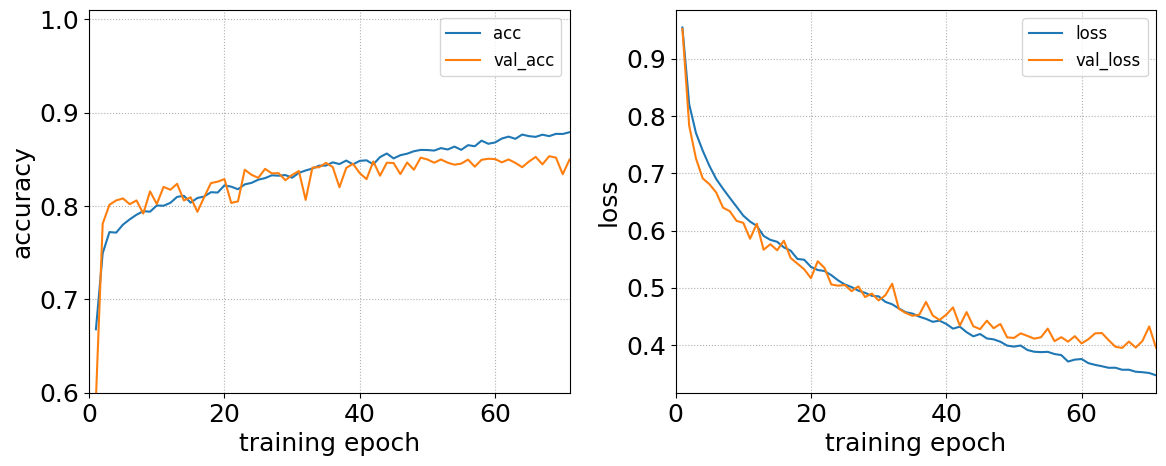

In [20]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.6,1.01)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();
fig.savefig('2label_acc_loss_ivar50.png', dpi=120)

### ROC Curve and Precision-Recall

Plot both the ROC curves per class and the class-averaged ROC curve.

In [21]:
flux=x_val[:,:,:]
y_pred = model.predict(flux)

162/162 [==============================] - 0s 1ms/step


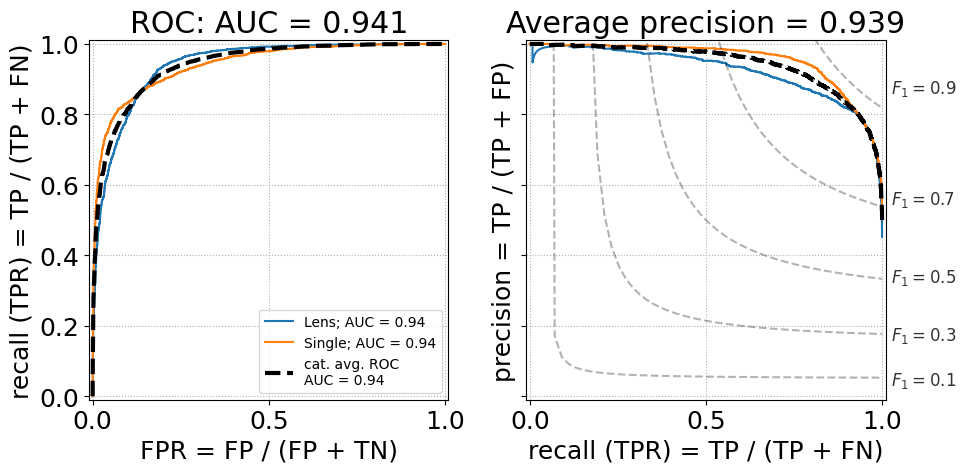

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val, y_pred)),
       aspect='equal')

fig.tight_layout()
fig.savefig('2label_roc_pr5_fluxivar.png', dpi=120)

### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

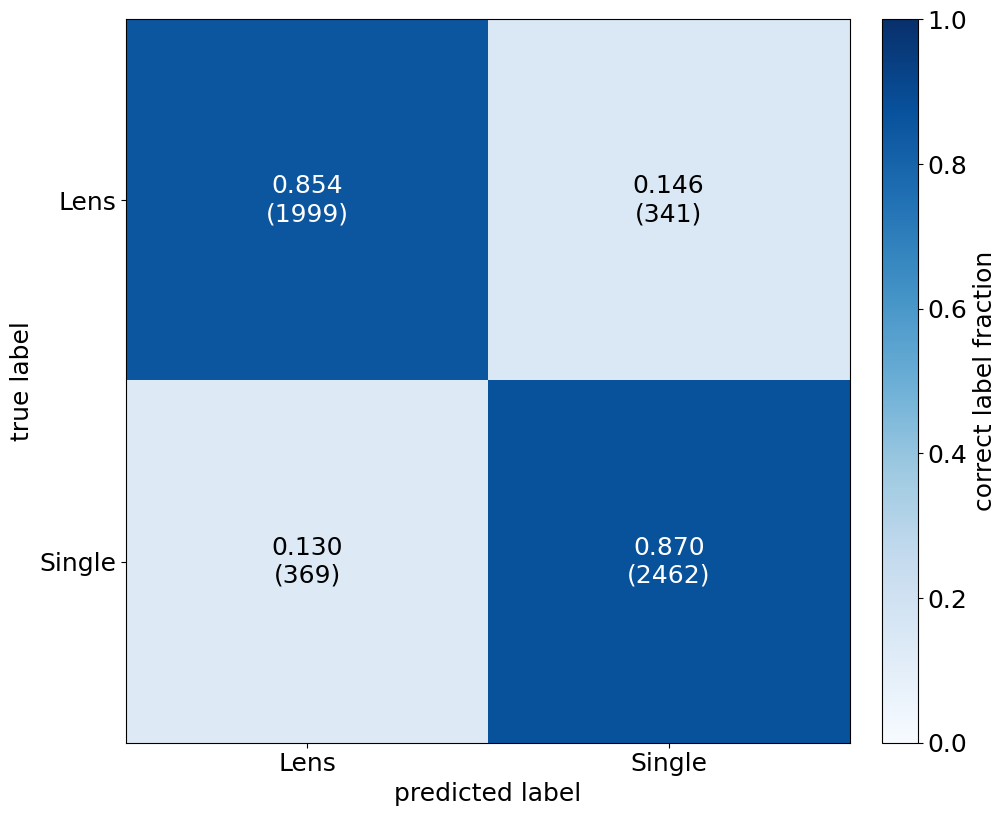

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('2label_cm_5_fluxivar_nocut.png', dpi=300, bbox_inches='tight')

In [27]:
model.save('fluxandivar_model')
# synthlens_fluxandivar_model -- uses flux and ivar but weird tile situation
#synthlensreduced_model --- more balanced sample of single and lens 
#synthlensfull_model ---was all data and 100 epochs
#synthlen_smodel ---- 40 percent of data 100 epochs
#synthlens_model ----original with 50 epochs

INFO:tensorflow:Assets written to: fluxandivar_model/assets


INFO:tensorflow:Assets written to: fluxandivar_model/assets


In [28]:
model.save('fluxandivar_model.h5')

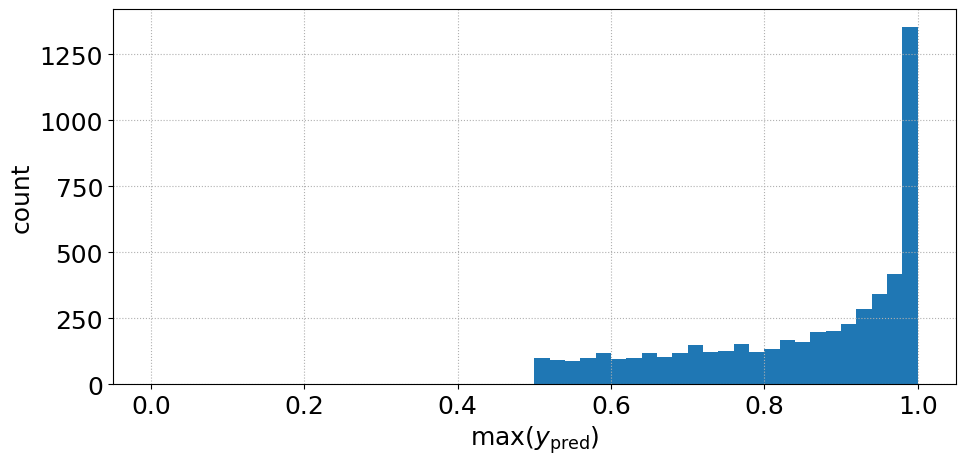

In [29]:
i = np.argmax(y_pred, axis=1)
y_max = np.max(y_pred, axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
ax.hist(y_max, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count')
ax.grid(ls=':')
fig.savefig('max_ypred.png', dpi=120)

In [30]:
np.sum(y_max > 0.95) / len(y_max)

0.3769096886482305

In [31]:
select = y_max > 0.995

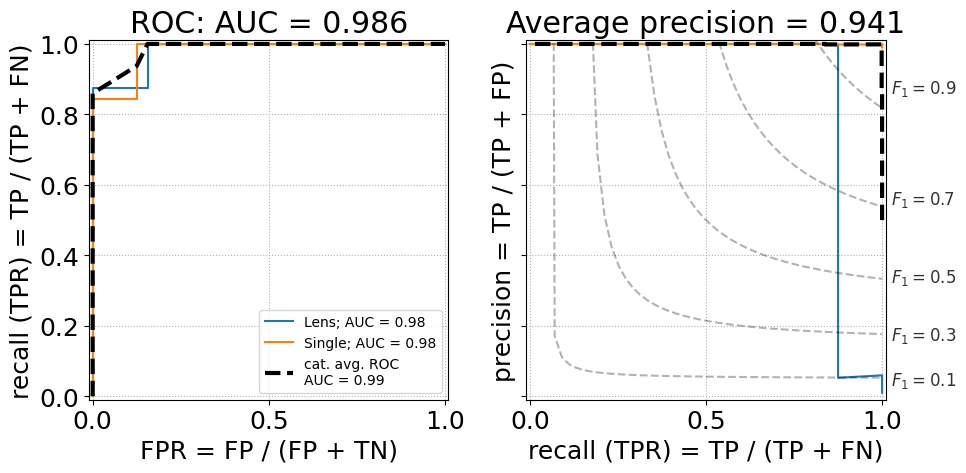

In [32]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[select][:,i], y_pred[select][:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[select][:,i], y_pred[select][:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val[select].ravel(), y_pred[select].ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val[select], y_pred[select])),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr_y99_5.png', dpi=120)

In [33]:
# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val[select].argmax(axis=1), y_pred[select].argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

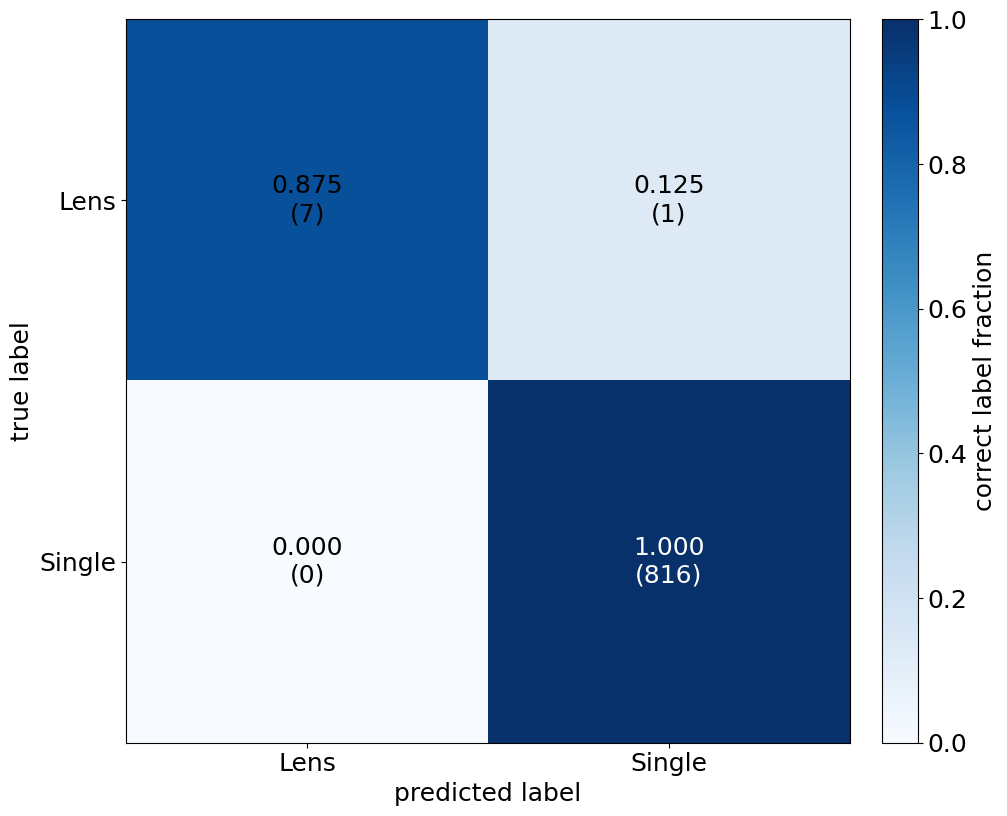

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

# thresh = 0.5*cm.max()
thresh = np.average(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm_ygt0.99_5.png', dpi=120)

In [35]:
len(y_pred), len(y_pred) - np.sum(select)

(5171, 4347)

In [ ]:
# import tensorflow
# from tensorflow import keras
# model = tensorflow.keras.models.load_model('fluxandivar_model.h5')